# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal
import set_rc_params as set_rc

%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']
reload(dt)
reload(set_rc)

# Global params
set_rc.set_rc_params()
root = pathlib.Path("/data")
classifier_model = GaussianNB

BIN_SIZE = .03  # sec
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'PMd')
MAX_HISTORY = 3  #int: no of bins to be added as history

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_target_on', 
                                         rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                        )

preprocessing

In [2]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

In [3]:
def prep_general (df):
    "preprocessing general!"
    time_signals = [signal for signal in pyal.get_time_varying_fields(df) if 'spikes' in signal]
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    for signal in time_signals:
        df_ = pyal.remove_low_firing_neurons(df, signal, 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in time_signals:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_


%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names


In [4]:
def custom_r2_func(y_true, y_pred):
    "$R^2$ value as squared correlation coefficient, as per Gallego, NN 2020"
    return stats.pearsonr(y_true, y_pred)[0] ** 2

custom_r2_scorer = make_scorer(custom_r2_func)

# Within animal decoding

select sessions of the same animal $A$ and $B$ to compute the the canonical axes, and then decode kinematics. One decoder per pair of sessions, similar to the NN paper.

decoder performance cross-validated on the second day in each pair

## Witihn animal, across sessions

In [5]:
if "__file__" not in dir():
    full_list = []
    for area in ('dualArea','PMd'):
        for animal, sessionList in GoodDataList[area].items():
            if 'Mr' in animal:
                continue  # to remove MrT
            full_list.append((animal,sessionList))
    full_list = [(animal,session) for animal,sessions in full_list for session in set(sessions)]

    # load the DFs
    warnings.filterwarnings("ignore")
    allDFs = []
    for animal, session in full_list:
        path = root/animal/session
        allDFs.append(prep_general(dt.load_pyal_data(path)))
    warnings.filterwarnings("default")

In [6]:
pairIndex_uni = []
for i, (animal1,session1) in enumerate(full_list):
    pairIndex_uni.append((i,[]))
    for j, (animal2,session2) in enumerate(full_list):
        if animal1 == animal2: continue
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue
        pairIndex_uni[-1][1].append(j)

In [20]:
MAX_HISTORY = 3  #int: no of bins

rng = np.random.default_rng(12345)
warnings.filterwarnings("ignore")
reg_scores = []
for id1, testList in pairIndex_uni:
    AllData = dt.get_data_array([allDFs[id1]]+[allDFs[testid] for testid in testList], prep_epoch, area=areas[1], model=n_components)
    # adding history -- there is no need for history
    AllData = dt.add_history_to_data_array(AllData, MAX_HISTORY)

    AllData1 = AllData[0,...] 
    _,n_trial,n_time,n_comp = AllData1.shape
    # resizing
    X1 = AllData1.reshape((-1,n_comp*n_time))
    AllTar = np.repeat(np.arange(8),n_trial)

    trial_index = np.arange(len(AllTar))
    rng.shuffle(trial_index)
    X_train, Y_train = X1[trial_index,:], AllTar[trial_index]

    # train the decoder
    classifier = classifier_model()
    classifier.fit(X_train, Y_train)

    for testId,_ in enumerate(testList):
        AllData2 = AllData[testId+1,...]  # index 1 is for the training dataset above
        # resizing
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        
        # align the decoder
        A,B,*_ = dt.canoncorr(X1, X2, fullReturn=True)
        X2_aligned = X2 @ B @ linalg.inv(A) 

        X2_aligned = X2_aligned.reshape((-1,n_comp*n_time))
        AllTar = np.repeat(np.arange(8),n_trial)
        
        rng.shuffle(trial_index)
        X_test, Y_test = X2_aligned[trial_index,:], AllTar[trial_index]
        
        # test the decoder
        _score = classifier.score(X_test,Y_test)
        reg_scores.append((id1,testId,_score))
warnings.filterwarnings("default")

pop_score_uni = []
for _,_,scores in reg_scores:
    pop_score_uni.append(scores)
pop_score_uni = np.array(pop_score_uni)

Text(0.5, 1.0, 'Target classifying --- universal classifier')

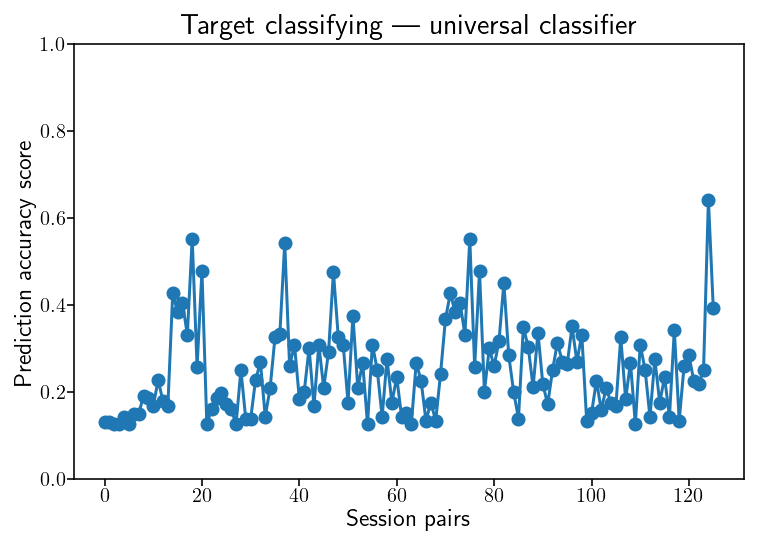

In [21]:
_,ax = plt.subplots()
ax.plot(pop_score_uni,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel('Prediction accuracy score')
ax.set_title('Target classifying --- universal classifier')